# FINAL MODEL
---

In [1]:
!pip install catboost

Import the essential libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
import pickle

In [3]:
PATH = ''

In [4]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

In [5]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,other_floor_type_damage_grade_2,geo_level_1_id,roof_type_damage_grade_1,outlier_score,other_floor_type_damage_grade_1,has_superstructure_mud_mortar_stone,ground_floor_type_damage_grade_1,geo_level_3_id,geo_level_2_id,foundation_type_damage_grade_1,area_percentage height_percentage,age^2,age height_percentage,age area_percentage,roof_type_damage_grade_3,roof_type_damage_grade_2,other_floor_type_damage_grade_3,height_percentage^2,height_percentage,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_adobe_mud,ground_floor_type_damage_grade_3,ground_floor_type_damage_grade_2,foundation_type_damage_grade_3,foundation_type_damage_grade_2,count_floors_pre_eq,area_percentage^2,area_percentage,age,damage_grade
0,-0.963635,-0.964020,-0.963475,0.963989,-0.963922,-0.000105,0.768891,-0.964010,-0.964005,-0.963569,0.763427,0.963490,-0.964012,-0.963809,-0.964024,-0.211381,0.963969,-0.963452,0.963717,-0.963952,0.594862,6,0.343728,0.120756,0.360445,1,0.368612,12198,487,0.378479,30.0,900.0,150.0,180.0,0.074091,0.58218,0.044693,25.0,5,0,0,1,0.059508,0.571880,0.048906,0.572615,2,36.0,6,30,3
1,-0.963910,-0.964027,-0.963992,0.964022,-0.964014,-0.001268,0.176790,-0.964025,-0.964025,-0.963868,0.763675,0.963846,-0.964026,-0.964007,-0.964027,-0.797116,0.964021,-0.963834,0.963936,-0.964017,0.594862,8,0.343728,0.106806,0.360445,1,0.333199,2812,900,0.378479,56.0,100.0,70.0,80.0,0.074091,0.58218,0.044693,49.0,7,0,0,0,0.082486,0.584315,0.048906,0.572615,2,64.0,8,10,2
2,-0.964027,-0.964028,-0.964028,0.964028,-0.964028,-0.964020,0.762888,-0.964028,-0.964028,-0.964027,0.007444,0.964027,-0.964028,-0.964028,-0.964028,-0.138342,0.964028,-0.964027,0.964027,-0.964028,0.544858,21,0.343728,0.149905,0.376243,1,0.368612,8973,363,0.378479,25.0,100.0,50.0,50.0,0.074091,0.58218,0.078899,25.0,5,0,0,0,0.059508,0.571880,0.048906,0.572615,2,25.0,5,10,3
3,-0.964027,-0.964028,-0.964028,0.964028,-0.964028,-0.964025,0.753681,-0.964028,-0.964028,-0.964027,0.007573,0.964027,-0.964028,-0.964028,-0.964028,-0.163955,0.964028,-0.964027,0.964028,-0.964028,0.544858,22,0.343728,0.133483,0.376243,1,0.368612,10694,418,0.378479,30.0,100.0,50.0,60.0,0.074091,0.58218,0.078899,25.0,5,0,0,0,0.059508,0.571880,0.048906,0.572615,2,36.0,6,10,2
4,-0.964008,-0.964028,-0.964027,0.964027,-0.964027,-0.064321,0.769178,-0.964027,-0.964024,-0.963994,0.763158,0.963992,-0.964027,-0.964027,-0.964028,-0.105160,0.964027,-0.963990,0.964013,-0.964027,0.544858,11,0.343728,0.086761,0.376243,0,0.368612,1488,131,0.378479,72.0,900.0,270.0,240.0,0.074091,0.58218,0.078899,81.0,9,0,0,1,0.059508,0.571880,0.048906,0.572615,3,64.0,8,30,3


In [6]:
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,other_floor_type_damage_grade_2,geo_level_1_id,roof_type_damage_grade_1,outlier_score,other_floor_type_damage_grade_1,has_superstructure_mud_mortar_stone,ground_floor_type_damage_grade_1,geo_level_3_id,geo_level_2_id,foundation_type_damage_grade_1,area_percentage height_percentage,age^2,age height_percentage,age area_percentage,roof_type_damage_grade_3,roof_type_damage_grade_2,other_floor_type_damage_grade_3,height_percentage^2,height_percentage,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_adobe_mud,ground_floor_type_damage_grade_3,ground_floor_type_damage_grade_2,foundation_type_damage_grade_3,foundation_type_damage_grade_2,count_floors_pre_eq,area_percentage^2,area_percentage,age
0,-0.964027,-0.964028,-0.964028,0.964028,-0.964028,-0.962469,0.478097,-0.964028,-0.964028,-0.964026,0.008201,0.964026,-0.964028,-0.964028,-0.964028,-0.504447,0.964028,-0.964026,0.964027,-0.964028,0.594862,17,0.343728,0.168273,0.360445,1,0.368612,11307,596,0.378479,42.0,400.0,120.0,140.0,0.074091,0.582180,0.044693,36.0,6,0,0,0,0.059508,0.571880,0.048906,0.572615,3,49.0,7,20
1,-0.963635,-0.964020,-0.963475,0.963989,-0.963922,-0.000105,0.769902,-0.964010,-0.964003,-0.963569,0.763156,0.963490,-0.964012,-0.963809,-0.964024,-0.097969,0.963969,-0.963452,0.963717,-0.963952,0.594862,6,0.343728,0.127960,0.360445,1,0.368612,11987,141,0.378479,65.0,625.0,125.0,325.0,0.074091,0.582180,0.044693,25.0,5,0,0,0,0.059508,0.571880,0.048906,0.572615,2,169.0,13,25
2,-0.964015,-0.964027,-0.964010,0.964005,-0.963881,-0.955200,0.767785,-0.964027,-0.963292,-0.964010,0.006841,0.964000,-0.963995,-0.964026,-0.964027,-0.122553,0.964025,-0.964000,0.964015,-0.964015,0.594862,22,0.343728,0.159008,0.360445,1,0.368612,10044,19,0.378479,20.0,25.0,25.0,20.0,0.074091,0.582180,0.044693,25.0,5,0,0,0,0.059508,0.571880,0.048906,0.572615,2,16.0,4,5
3,-0.964027,-0.964028,-0.964027,0.964027,-0.964005,-0.963992,0.767341,-0.964028,-0.963745,-0.964027,0.006903,0.964027,-0.964027,-0.964028,-0.964028,-0.129631,0.964028,-0.964027,0.964027,-0.964027,0.511056,26,0.045047,-0.068702,0.265919,0,0.053389,633,39,0.378479,57.0,0.0,0.0,0.0,0.472780,0.482173,0.223025,9.0,3,0,1,0,0.419184,0.527427,0.048906,0.572615,1,361.0,19,0
4,-0.964027,-0.964028,-0.964028,0.964028,-0.964028,-0.962469,0.767176,-0.964028,-0.964028,-0.964026,0.007401,0.964026,-0.964028,-0.964028,-0.964028,-0.119551,0.964028,-0.964026,0.964027,-0.964028,0.594862,17,0.383932,0.144733,0.360445,1,0.368612,7970,289,0.378479,56.0,225.0,105.0,120.0,0.063759,0.552309,0.044693,49.0,7,0,0,0,0.059508,0.571880,0.048906,0.572615,3,64.0,8,15


In [7]:
print("train: ", train.shape)
print("test: ", test.shape)

train:  (260601, 51)
test:  (86868, 50)


In [8]:
X = train.iloc[:, 0:-1].values
y = train.iloc[:, -1].values

### Stacking CLassifier
#### Base Estimators:

* XGBClassifier(max_depth=6)
* LGBMClassifier(max_depth=8, learning_rate=0.25)
* CatBoostClassifier(verbose=False) 

#### Meta Estimator:
* RandomForestClassifier(max_depth = 10)

In [9]:
estimators = [
     ('xgb', XGBClassifier(max_depth=6)),
     ('lgb', LGBMClassifier(max_depth=8, learning_rate=0.25)),
     ('cat', CatBoostClassifier(verbose=False))]

clf = StackingClassifier(
     estimators=estimators, final_estimator=RandomForestClassifier(max_depth = 10))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

In [11]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
clf.fit(X_train, y_train)

StackingClassifier(cv=None,
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_...
                                                          criterion='

train:  0.7453611324294364
test:  0.7323586969034189


Text(0.5, 1.0, 'Test')

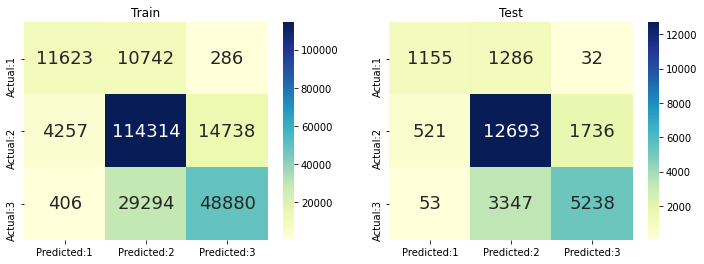

In [14]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("train: ",f1_score(y_train, y_train_pred, average='micro'))
print("test: ",f1_score(y_test, y_test_pred, average='micro'))

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

conf_matrix_train = pd.DataFrame(data=cm_train,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                      index=['Actual:1','Actual:2','Actual:3'])
conf_matrix_test = pd.DataFrame(data=cm_test,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                      index=['Actual:1','Actual:2','Actual:3'])

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(conf_matrix_train,
          annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0],cmap="YlGnBu").set_title("Train")
sb.heatmap(conf_matrix_test, 
          annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1],cmap="YlGnBu").set_title("Test")

In [20]:
filename = "final_model"
pickle.dump(clf, open(filename, 'wb'))

In [23]:
submission = pd.read_csv('submission_format.csv')
test_data = test.iloc[:, :].values
test_data = sc.transform(test_data)
final_prediction = clf.predict(test_data)
submission.drop(['damage_grade'],axis=1,inplace=True)
submission['damage_grade'] = final_prediction
submission.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3


In [24]:
submission.to_csv("submission.csv",index=False)